# **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pandas_datareader as web
import datetime as dt

# **Installing libraries**

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 12.3 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# **Data collected from https://finance.yahoo.com/**

In [3]:
import yfinance as yf
crypto_currency = 'BTC'
against_currency = 'EUR'
start =  dt.datetime(2019,9,18) 
#start = dt.datetime(2020,4,10)
end = dt.datetime(2021,11,8) #dt.datetime.now()
search = crypto_currency +'-'+ against_currency
data = yf.download(search, start=start, end=end)
data.round(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-18,9253.40,9316.92,9240.34,9246.49,9246.49,14660255693
2019-09-19,9248.52,9319.45,8917.57,9292.97,9292.97,18047239238
2019-09-20,9292.89,9334.07,9194.60,9239.48,9239.48,13370761401
2019-09-21,9241.30,9245.34,9075.29,9092.54,9092.54,12182959742
2019-09-22,9096.53,9142.63,9004.77,9138.95,9138.95,11978776314
...,...,...,...,...,...,...
2021-11-04,54190.31,54351.23,52647.95,53180.64,53180.64,28225688676
2021-11-05,53187.43,54139.52,52592.56,52915.76,52915.76,26494469926
2021-11-06,52866.59,53318.32,52083.06,53263.60,53263.60,25187135416


# **Cleaning data - filling NaNs and clearing duplicates**

In [4]:
dates_range = pd.date_range(start=start,end=end)
dates = dates_range.to_frame()
dates.index.name = 'Date'
dates.index = pd.to_datetime(dates.index, errors='coerce', format='%Y-%m-%d')

prices = data[['Open','High','Low','Close','Volume']]
prices = dates.join(prices)
prices = data[['Open','High','Low','Close','Volume']]
prices = prices[~prices.index.duplicated(keep='first')]
prices = prices.interpolate()
prices[prices['Close'].isnull()]

,Open,High,Low,Close,Volume
Date,,,,,


In [5]:
prices

,Open,High,Low,Close,Volume
Date,,,,,
2019-09-18,9253.401367,9316.917969,9240.340820,9246.486328,14660255693
2019-09-19,9248.524414,9319.454102,8917.574219,9292.973633,18047239238
2019-09-20,9292.886719,9334.069336,9194.604492,9239.483398,13370761401
2019-09-21,9241.304688,9245.341797,9075.292969,9092.541992,12182959742
2019-09-22,9096.534180,9142.628906,9004.768555,9138.951172,11978776314
...,...,...,...,...,...
2021-11-04,54190.312500,54351.234375,52647.949219,53180.636719,28225688676
2021-11-05,53187.429688,54139.523438,52592.558594,52915.761719,26494469926
2021-11-06,52866.589844,53318.316406,52083.062500,53263.601562,25187135416


## Simplify volume data

In [6]:
def mod_size(i):
    return len("%i" % i)

min_digits_of_vol = 4

vol_min = prices['Volume'].min(axis=0)
vol_max = prices['Volume'].max(axis=0)

vol_min_len = mod_size(vol_min)
vol_max_len = mod_size(vol_max)

prices['Volume'] = round((prices['Volume']/(10**(vol_min_len-min_digits_of_vol))),2)
prices['Volume']

Date
2019-09-18    1466.03
2019-09-19    1804.72
2019-09-20    1337.08
2019-09-21    1218.30
2019-09-22    1197.88
               ...   
2021-11-04    2822.57
2021-11-05    2649.45
2021-11-06    2518.71
2021-11-07    2137.46
2021-11-08    3548.83
Name: Volume, Length: 779, dtype: float64

# **Plotting data**

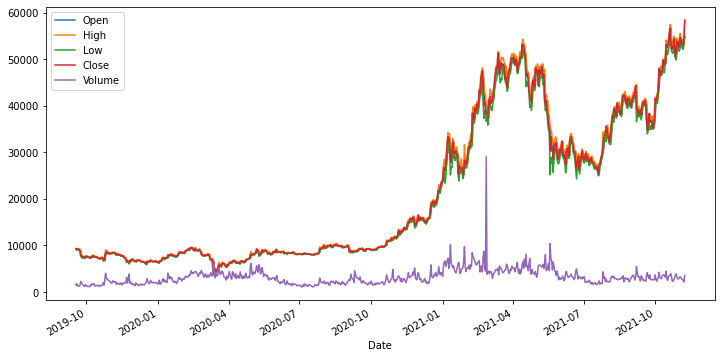

In [7]:
prices.plot(figsize=(12,6))

# **Splitting data (training and test set) and scaling data**

In [8]:
training_percentage = 0.8

#Splitting Price Data
X = prices
training_size = int(len(X) * training_percentage)
train = X[0:training_size]
test = X[training_size:len(X)]

#Scaling Price Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# **Creating data structure for training and reshaping**

In [9]:
#Training data structure
X_train = []
y_train = []
timesteps = 21

for i in range(timesteps, len(train)):
  X_train.append(scaled_train[i-timesteps:i, 0:scaled_train.shape[1]])
  y_train.append(scaled_train[i:i+1, 0])
  
X_train,y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  #(batch_size->number of observations, timesteps, input_dimensions)

# **Building the RNN (LSTM)**

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

num_of_lstms = 1
neurons_per_lstm = 50 
num_of_epochs = 75
optimizer_name = 'adam' # RMSProp/adam

# Initialize the RNN
regressor = Sequential()

# Add 1st LSTM layer and some Dropout regularization
regressor.add(LSTM(units=neurons_per_lstm, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#For more layers return_sequences=True
regressor.add(Dropout(0.2))

# Add 2nd LSTM layer and some Dropout regularization
#regressor.add(LSTM(units=neurons_per_lstm, return_sequences=True))
#regressor.add(Dropout(0.2))

# Add 3rd LSTM layer and some Dropout regularization
#regressor.add(LSTM(units=neurons_per_lstm, return_sequences=True))
#regressor.add(Dropout(0.2))

# Add 4th LSTM layer and some Dropout regularization
#regressor.add(LSTM(units=neurons_per_lstm)) # return_sequences=False is the default value for return_sequences
#regressor.add(Dropout(0.2))

# Add output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=optimizer_name, loss='mean_squared_error') 

# Fitting the RNN to the training set
history = regressor.fit(X_train, y_train, epochs=num_of_epochs, batch_size=32)

Epoch 1/75
19/19 [==============================] - 3s 12ms/step - loss: 0.0059
Epoch 2/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0034
Epoch 3/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 4/75
19/19 [==============================] - 0s 13ms/step - loss: 0.0027
Epoch 5/75
19/19 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 6/75
19/19 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 7/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 8/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 9/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 10/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 11/75
19/19 [==============================] - 0s 12ms/step - loss: 0.0017
Epoch 12/75
19/19 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 13/75
19/19 [==================

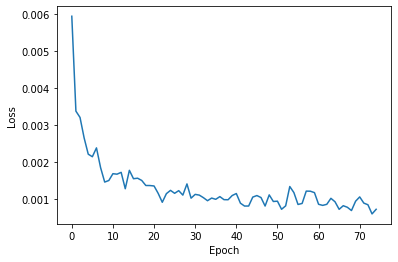

In [11]:
loss_per_epoch = regressor.history.history['loss']
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

# **Predicting using the RNN**

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

scaled_dataset_total = np.concatenate((scaled_train, scaled_test), axis=0)
inputs = scaled_dataset_total[len(scaled_dataset_total) - len(scaled_test) - timesteps:]

#Creating Data Structure
X_test = []

for i in range(timesteps, timesteps + len(test)):
  X_test.append(inputs[i-timesteps:i, 0:scaled_train.shape[1]])

X_test = np.array(X_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  #(batch_size->number of observations, timesteps, input_dimensions)

#Predict
scaled_predicted = regressor.predict(X_test)

#Prepare data for inverse transform (inverse scaler expects 2 columns because it was fitted with 2 columns)
predicted_copies = np.repeat(scaled_predicted, scaled_train.shape[1], axis=-1)

#Inverse Scaling to prediction
predicted = scaler.inverse_transform(predicted_copies)[:,0]
predicted_df = pd.DataFrame(predicted, index = test.index)

#Calculating Error
rmse = sqrt(mean_squared_error(test['Close'], predicted_df))
relative_rmse = sqrt(mean_squared_error(test['Close'], predicted_df))/test['Close'].std()

# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['Close'],predicted_df)


In [13]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test.index,
    y=test['Close'],
    name = 'Real Value',
    marker=dict(color="blue"),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=predicted_df.index,
    y=predicted_df[0],
    name = 'Predicted Value',
    marker=dict(color="red"),
    showlegend=True
))

fig.update_layout(
    title=crypto_currency+" price prediction",
    title_x=0.5,
    xaxis_title="Date",
    yaxis_title=crypto_currency+" value in "+against_currency,
)

s = f"""
Prediction Variables
{'-'*35}
Amount of training data: {len(train)}
Amount of LSTM layers: {num_of_lstms}
Timesteps: {timesteps}
Neurons per LSTM layer: {neurons_per_lstm}
Training/Test: {int(training_percentage*100)}% - {int(100-training_percentage*100)}%
RMSE: {round(rmse,2)}
Relative/Normalized RMSE: {round((relative_rmse*100),2)}%
MAPE: {round(mape,2)}%
Optimizer: {optimizer_name}
Epochs: {num_of_epochs}
{'-'*35}
"""

# **Results**

In [14]:
fig.show()
print(s, end='')
print("based on values:", end=' ')
for col in (prices.columns): 
  print(col, end=' ')


Prediction Variables
-----------------------------------
Amount of training data: 623
Amount of LSTM layers: 1
Timesteps: 21
Neurons per LSTM layer: 50
Training/Test: 80% - 20%
RMSE: 1875.13
Relative/Normalized RMSE: 21.27%
MAPE: 26.77%
Optimizer: adam
Epochs: 75
-----------------------------------
based on values: Open High Low Close Volume 